Rotation angles: [3.43985971 4.22800824 5.57135362 4.21490119 0.13782452 6.07952803]
Coupling map:


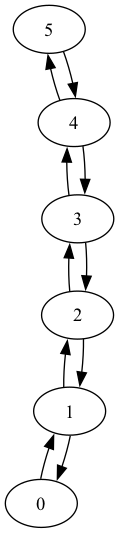

In [1]:
from gate_level.spillover_noise_use_case.generic_spillover.spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np

num_qubits = 6
rotation_axes = ["rx", "ry", "rx", "ry", "rx", "ry"]
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
rotation_parameters = ParameterVector("θ", num_qubits)
cm = CouplingMap.from_line(num_qubits, True)
print("Rotation angles:", rotation_angles)
print("Coupling map:")
cm.draw()

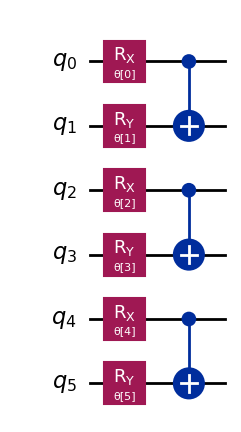

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

In [3]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.025  # γ_0->1
gamma_matrix[0, 3] = 0.3  # γ_0->3
gamma_matrix[1, 2] = 0.25  # γ_1->2
gamma_matrix[2, 3] = 0.0  # γ_2->3
gamma_matrix[3, 2] = 0.0  # γ_3->2
gamma_matrix[4, 3] = 0.025  # γ_4->3
gamma_matrix[5, 4] = 0.025  # γ_5->4

gamma_matrix = np.random.uniform(0, 1, (num_qubits, num_qubits))
print("Gamma matrix:")
print(gamma_matrix)

Gamma matrix:
[[0.98716003 0.59565373 0.59314658 0.0631718  0.76563588 0.51799641]
 [0.22879651 0.04361316 0.62621199 0.45598221 0.87931859 0.57165579]
 [0.93344291 0.71551889 0.44552394 0.93421755 0.97601165 0.67712315]
 [0.17724835 0.45560329 0.84208862 0.07238302 0.49929644 0.2060112 ]
 [0.33693923 0.47259986 0.24802798 0.31893061 0.04123352 0.72842803]
 [0.80945732 0.5102657  0.22589747 0.65076444 0.10400153 0.51556625]]


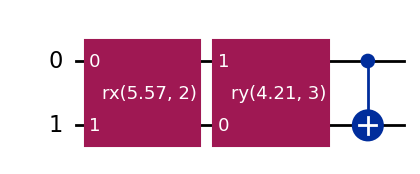

In [4]:
pm = PassManager(
    [
        LocalSpilloverNoiseAerPass(
            spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
            target_subsystem=(2, 3),
        )
    ]
)
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
qc_noisy = pm.run(circuit.assign_parameters(param_dict))
qc_noisy.draw("mpl")

In [5]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
    coupling_map=cm,
)

In [6]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '5974fb1eb39742978606d72b93b47e4d',
   'operations': ['rx(5.57, 2)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[-0.47867895+0.27854089j,  0.83214944+0.02843835j,
                0.        +0.j        ,  0.        +0.j        ],
              [-0.83214944+0.02843835j, -0.47867895-0.27854089j,
                0.        +0.j        ,  0.        +0.j        ],
              [ 0.        +0.j        ,  0.        +0.j        ,
               -0.47867895+0.27854089j,  0.83214944+0.02843835j],
              [ 0.        +0.j        ,  0.        +0.j        ,
               -0.83214944+0.02843835j, -0.47867895-0.27854089j]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0, 1)]},
  {'type': 'qerror',
   'id': 'daf5095360af4c28a443e320ee9b2444',
   'operations': ['ry(4.21, 3)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[ 0.84191146+0.45016907j,  0.        +0.

In [7]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[ 0.47922143+0.j        ,  0.        +0.17814922j,
            0.80556201+0.j        ,  0.        +0.29946541j],
          [ 0.        -0.29946541j, -0.80556201+0.j        ,
            0.        +0.17814922j,  0.47922143+0.j        ],
          [-0.80556201+0.j        ,  0.        -0.29946541j,
            0.47922143+0.j        ,  0.        +0.17814922j],
          [ 0.        +0.17814922j,  0.47922143+0.j        ,
            0.        +0.29946541j,  0.80556201+0.j        ]],
         input_dims=(2, 2), output_dims=(2, 2))


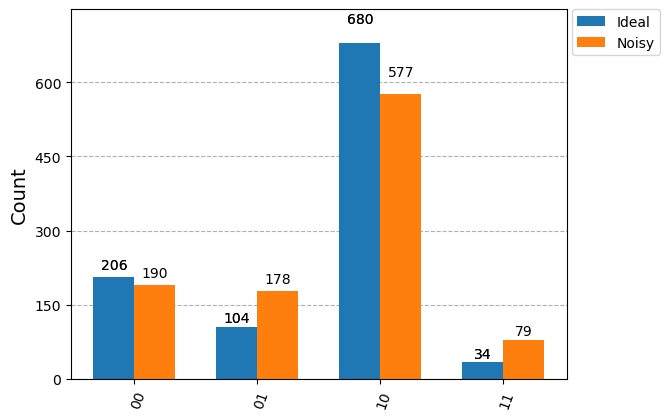

In [8]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [9]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
qc_noisy_ideal_state.save_statevector()
qc_noisy_state.save_statevector()

ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
noisy_state = backend.run(qc_noisy_state).result().get_statevector()

In [10]:
output_fidelity = state_fidelity(ideal_state, noisy_state)
output_fidelity

0.6748274951052272

In [11]:
ideal_state

Statevector([ 0.47922143+0.j        ,  0.        -0.29946541j,
             -0.80556201+0.j        ,  0.        +0.17814922j],
            dims=(2, 2))


In [12]:
noisy_state

Statevector([-0.37710695+0.22357348j,  0.37773944-0.22986641j,
              0.63390954-0.37582273j, -0.22471372+0.13674542j],
            dims=(2, 2))


In [13]:
from qiskit import QuantumRegister
from rl_qoc.helpers import get_gate

# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))

    my_qc.u(
        optimal_params[0] + params[0],
        optimal_params[1] + params[1],
        optimal_params[2] + params[2],
        q_reg[0],
    )
    my_qc.u(
        optimal_params[3] + params[3],
        optimal_params[4] + params[4],
        optimal_params[5] + params[5],
        q_reg[1],
    )

    my_qc.rzx(optimal_params[6] + params[6], q_reg[0], q_reg[1])
    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [18]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    QiskitConfig,
)

action_space = Box(low=-np.pi, high=np.pi, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [0, 1]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    pass_manager=pm,
    skip_transpilation=True,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(),
)
env = ContextAwareQuantumEnvironment(q_env_config, circuit_context=qc_noisy)

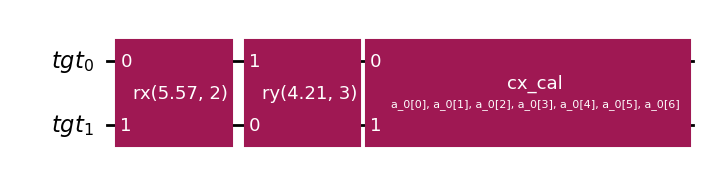

In [19]:
env.circuits[0].draw(output="mpl")

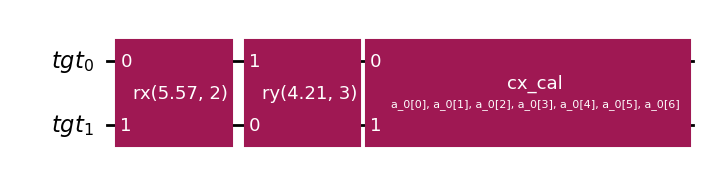

In [20]:
env.backend_info.custom_transpile(env.circuits[0]).draw("mpl")